In [89]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import date
import re

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error


from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  mean_squared_error, r2_score
import tensorflow as tf


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


In [90]:
current_year = date.today().year
print(f"current year: {current_year}")
train_dir = os.path.join('/kaggle/input/playground-series-s4e9/train.csv')
test_dir = os.path.join('/kaggle/input/playground-series-s4e9/test.csv')

current year: 2024


In [91]:
train_dataset = pd.read_csv(train_dir, index_col=['id'])
test_dataset = pd.read_csv(test_dir, index_col=['id'])

In [92]:
print(f"*******************************Training Dataset**********************************")
print(f"\n{train_dataset}\n")
print(f"*******************************Test Dataset**********************************")
print(f"\n{test_dataset}")

*******************************Training Dataset**********************************

                brand                     model  model_year  milage  \
id                                                                    
0                MINI             Cooper S Base        2007  213000   
1             Lincoln                     LS V8        2002  143250   
2           Chevrolet         Silverado 2500 LT        2002  136731   
3             Genesis          G90 5.0 Ultimate        2017   19500   
4       Mercedes-Benz               Metris Base        2021    7388   
...               ...                       ...         ...     ...   
188528       Cadillac     Escalade ESV Platinum        2017   49000   
188529  Mercedes-Benz  AMG C 43 AMG C 43 4MATIC        2018   28600   
188530  Mercedes-Benz    AMG GLC 63 Base 4MATIC        2021   13650   
188531           Audi          S5 3.0T Prestige        2022   13895   
188532        Porsche                Macan Base        2016   595

In [93]:
# Size of the dataset, columns and feature names of the dataset
print(f"training dataset shape: {train_dataset.shape}")
print(f"test dataset shape: {test_dataset.shape}\n")
column_names = [col for col in train_dataset.columns]
feature_names = [col for col in train_dataset.columns if col!='price'] # price is the target label/variable ---> cont. numerical dataset
object_cols = [col for col in train_dataset.select_dtypes(include=['object']).columns]
print(f"{column_names}\n")
print(f"{feature_names}\n")
print(f"categorical/non-numerical features: {object_cols}\n")
print(f"test_dataset features:\n{list(test_dataset.columns)}") # id is the index value

training dataset shape: (188533, 12)
test dataset shape: (125690, 11)

['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'price']

['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']

categorical/non-numerical features: ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']

test_dataset features:
['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']


In [94]:
print(f"************************Training Dataset*********************\n")
print(f"{train_dataset.describe()}\n")
print(f"************************Test Dataset*********************\n")
print(f"{test_dataset.describe()}")

************************Training Dataset*********************

          model_year         milage         price
count  188533.000000  188533.000000  1.885330e+05
mean     2015.829998   65705.295174  4.387802e+04
std         5.660967   49798.158076  7.881952e+04
min      1974.000000     100.000000  2.000000e+03
25%      2013.000000   24115.000000  1.700000e+04
50%      2017.000000   57785.000000  3.082500e+04
75%      2020.000000   95400.000000  4.990000e+04
max      2024.000000  405000.000000  2.954083e+06

************************Test Dataset*********************

          model_year         milage
count  125690.000000  125690.000000
mean     2015.797526   66042.581510
std         5.673797   50223.858435
min      1974.000000     100.000000
25%      2013.000000   24500.000000
50%      2017.000000   57500.000000
75%      2020.000000   95798.000000
max      2024.000000  405000.000000


In [95]:
# checking and correcting anomalies
# sub function to convert certain categorical features's cat values to lower cases for generalization 
def cat_to_lower(cat):
    if isinstance(cat, str) and not cat.islower():
        return cat.lower()
    elif pd.isna(cat):
        return np.nan
    else:
        return cat

train_dataset_inter = train_dataset.copy()
test_dataset_inter = test_dataset.copy()
def convert_cats_to_lower(dataset, features):
    dataset_copy = dataset.copy()
    for feat in features:
        dataset_copy[feat] = dataset_copy[feat].apply(lambda x: cat_to_lower(x))
    return dataset_copy

train_dataset_inter = convert_cats_to_lower(train_dataset_inter, ['brand','model','fuel_type','engine','transmission','int_col', 'ext_col', 'accident'])
test_dataset_inter = convert_cats_to_lower(test_dataset_inter, ['brand','model','fuel_type','engine','transmission','int_col', 'ext_col', 'accident'])

In [96]:
print(f"************************Training Dataset*********************\n")
print(f"{train_dataset_inter.head()}")
print(f"************************Test Dataset*********************\n")
print(f"{test_dataset_inter.head()}")

************************Training Dataset*********************

            brand              model  model_year  milage      fuel_type  \
id                                                                        
0            mini      cooper s base        2007  213000       gasoline   
1         lincoln              ls v8        2002  143250       gasoline   
2       chevrolet  silverado 2500 lt        2002  136731  e85 flex fuel   
3         genesis   g90 5.0 ultimate        2017   19500       gasoline   
4   mercedes-benz        metris base        2021    7388       gasoline   

                                               engine  \
id                                                      
0        172.0hp 1.6l 4 cylinder engine gasoline fuel   
1        252.0hp 3.9l 8 cylinder engine gasoline fuel   
2   320.0hp 5.3l 8 cylinder engine flex fuel capab...   
3        420.0hp 5.0l 8 cylinder engine gasoline fuel   
4        208.0hp 2.0l 4 cylinder engine gasoline fuel   

           

In [97]:
model_year = list(train_dataset_inter['model_year'].unique())

def transmission_type_sub(cat):
    if isinstance(cat, str) and 'a/t' in cat or 'at' in cat or 'automatic' in cat:
        return 'automatic'
    elif isinstance(cat, str) and 'm/t' in cat or 'mt' in cat or 'manual' in cat:
        return 'manual'
    elif pd.isna(cat):
        return np.nan
    else:
        return 'other'
    
def year_to_age(cat):
    if cat in model_year:
        return (current_year-cat)
    elif pd.isna(cat):
        return np.nan

    
def replace_anomaliesv1(dataset, features):
    dataset_copy = dataset.copy()
    for feat in features:
        dataset_copy[feat] = dataset_copy[feat].apply(lambda x: transmission_type_sub(x))
    return dataset_copy


fuel_type = ['gasoline','e85 flex fuel','hybrid','diesel','plug-in hybrid']

def fuel_corr(cat):
    if cat in fuel_type and cat != 'e85 flex fuel':
        return cat
    elif cat == 'e85 flex fuel':
        return 'flex fuel'
    elif pd.isna(cat):
        return np.nan
    else:
        return 'Rare'
    

train_int2 = replace_anomaliesv1(train_dataset_inter, ['transmission'])
train_int2['age_of_car'] = train_int2['model_year'].apply(lambda x: year_to_age(x))
train_int2['fuel_type'] = train_int2['fuel_type'].apply(lambda x: fuel_corr(x))

test_int2 = replace_anomaliesv1(test_dataset_inter, ['transmission'])
test_int2['age_of_car'] = test_int2['model_year'].apply(lambda x: year_to_age(x))
test_int2['fuel_type'] = test_int2['fuel_type'].apply(lambda x: fuel_corr(x))

train_int3 = train_int2.copy()
test_int3 = test_int2.copy()

In [98]:
# creating new features from engine info to reduce the over-encoding issue which may cause problems of overfitting
train_int3['engine_power'] = train_int3['engine'].str.extract(r'(\d+\.\d+)(?=hp)').astype(float)
train_int3['cylinder_volume'] = train_int3['engine'].str.extract(r'(\d+\.\d+)(?=l)').astype(float)
train_int3['extracted_fuel_type'] = train_int3['engine'].str.extract(r'(gasoline|diesel|electric|plug-in electric/gas|flex fuel capability)').astype(str)


test_int3['engine_power'] = test_int3['engine'].str.extract(r'(\d+\.\d+)(?=hp)').astype(float)
test_int3['cylinder_volume'] = test_int3['engine'].str.extract(r'(\d+\.\d+)(?=l)').astype(float)
test_int3['extracted_fuel_type'] = test_int3['engine'].str.extract(r'(gasoline|diesel|electric|plug-in electric/gas|flex fuel capability)').astype(str)

In [99]:
extracted_fuel_type = ['gasoline','flex fuel capability','electric','diesel','plug-in electric/gas']

def extracted_fuel_corr(cat):
    if (cat in extracted_fuel_type) and (cat != 'flex fuel capability' and cat != 'plug-in electric/gas'):
        return cat
    elif cat == 'flex fuel capability':
        return 'flex fuel'
    elif cat == 'plug-in electric/gas':
        return 'plug-in hybrid'
    elif pd.isna(cat) or cat == 'nan':
        return np.nan
    else:
        return cat
    
train_int3['extracted_fuel_type'] = train_int3['extracted_fuel_type'].apply(lambda x: extracted_fuel_corr(x))
test_int3['extracted_fuel_type'] = test_int3['extracted_fuel_type'].apply(lambda x: extracted_fuel_corr(x))

train_dataset_hlfilt = train_int3.copy()
test_dataset_hlfilt = test_int3.copy()

In [100]:
# checking the dataset feature datas
def check_features(dataset, column_names, normalize=False):
    for col in column_names:
        if normalize==False:
            print(f"{dataset[col].value_counts()}\n")
        else:
            print(f"{dataset[col].value_counts(normalize=True)*100}\n")
            
        
# checking the unique datas of each features
def check_unique_datas(dataset, column_names):
    for col in column_names:
        print(f"{col}: {dataset[col].unique()}\n")
    

print(f"***************Training Dataset***************\n") 
check_features(train_dataset_hlfilt, list(train_dataset_hlfilt.columns))        
print(f"\n")

***************Training Dataset***************

brand
ford             23088
mercedes-benz    19172
bmw              17028
chevrolet        16335
audi             10887
porsche          10612
land              9525
toyota            8850
lexus             8643
jeep              6474
cadillac          4674
ram               4249
nissan            3930
tesla             3738
infiniti          3276
gmc               3215
dodge             3133
mazda             2719
kia               2497
lincoln           2423
subaru            2381
acura             2282
honda             2101
hyundai           2045
volkswagen        1765
jaguar            1319
bentley           1155
mini              1064
genesis            969
buick              940
maserati           939
lamborghini        809
chrysler           727
volvo              723
alfa               682
rivian             590
rolls-royce        561
mitsubishi         551
pontiac            538
hummer             520
ferrari            359
mcl

In [101]:
print(f"{train_dataset_hlfilt['fuel_type'].value_counts()}\n")
print(f"{train_dataset_hlfilt['extracted_fuel_type'].value_counts()}")

train_dataset_hlfilt['combined_fuel_type'] = train_dataset_hlfilt['fuel_type'].combine_first(train_dataset_hlfilt['extracted_fuel_type'])
print(f"{train_dataset_hlfilt['combined_fuel_type'].value_counts()}")

fuel_type
gasoline          165940
hybrid              6832
flex fuel           5406
diesel              3955
Rare                 796
plug-in hybrid       521
Name: count, dtype: int64

extracted_fuel_type
gasoline          139734
electric            7029
flex fuel           5168
diesel              4119
plug-in hybrid       537
Name: count, dtype: int64
combined_fuel_type
gasoline          165986
hybrid              6832
flex fuel           5407
electric            4857
diesel              3957
Rare                 796
plug-in hybrid       521
Name: count, dtype: int64


In [102]:
print(f"{test_dataset_hlfilt['fuel_type'].value_counts()}\n")
print(f"{test_dataset_hlfilt['extracted_fuel_type'].value_counts()}\n")

test_dataset_hlfilt['combined_fuel_type'] = test_dataset_hlfilt['fuel_type'].combine_first(test_dataset_hlfilt['extracted_fuel_type'])
print(f"{test_dataset_hlfilt['combined_fuel_type'].value_counts()}")

fuel_type
gasoline          110533
hybrid              4676
flex fuel           3523
diesel              2686
Rare                 552
plug-in hybrid       337
Name: count, dtype: int64

extracted_fuel_type
gasoline          93290
electric           4592
flex fuel          3383
diesel             2770
plug-in hybrid      356
Name: count, dtype: int64

combined_fuel_type
gasoline          110570
hybrid              4676
flex fuel           3523
electric            3232
diesel              2687
Rare                 552
plug-in hybrid       338
Name: count, dtype: int64


In [103]:
print(f"***************Training Dataset***************\n")       
check_unique_datas(train_dataset_hlfilt, list(train_dataset_hlfilt.columns))
print(f"\n")

***************Training Dataset***************

brand: ['mini' 'lincoln' 'chevrolet' 'genesis' 'mercedes-benz' 'audi' 'ford'
 'bmw' 'tesla' 'cadillac' 'land' 'gmc' 'toyota' 'hyundai' 'volvo'
 'volkswagen' 'buick' 'rivian' 'ram' 'hummer' 'alfa' 'infiniti' 'jeep'
 'porsche' 'mclaren' 'honda' 'lexus' 'dodge' 'nissan' 'jaguar' 'acura'
 'kia' 'mitsubishi' 'rolls-royce' 'maserati' 'pontiac' 'saturn' 'bentley'
 'mazda' 'subaru' 'ferrari' 'aston' 'lamborghini' 'chrysler' 'lucid'
 'lotus' 'scion' 'smart' 'karma' 'plymouth' 'suzuki' 'fiat' 'saab'
 'bugatti' 'mercury' 'polestar' 'maybach']

model: ['cooper s base' 'ls v8' 'silverado 2500 lt' ... 'e-golf se'
 'integra w/a-spec tech package' 'ioniq plug-in hybrid sel']

model_year: [2007 2002 2017 2021 2018 2016 2020 2015 2011 2013 2023 2019 2012 2014
 2008 2009 2022 2003 2005 2001 2006 2000 2010 2004 1997 1998 1999 1994
 1993 1996 1995 2024 1974 1992]

milage: [213000 143250 136731 ...   4721   2922 134603]

fuel_type: ['gasoline' 'flex fuel' nan 

In [104]:
print(f"***************Test Dataset***************\n")       
check_features(test_dataset_hlfilt, list(test_dataset.columns))
print(f"\n")

***************Test Dataset***************

brand
ford             15265
mercedes-benz    12875
bmw              11286
chevrolet        10698
audi              7289
porsche           7153
land              6348
toyota            6084
lexus             5729
jeep              4412
cadillac          3059
ram               2753
nissan            2674
tesla             2387
infiniti          2123
gmc               2094
dodge             2071
mazda             1770
kia               1750
lincoln           1593
subaru            1591
acura             1567
honda             1436
hyundai           1308
volkswagen        1222
jaguar             934
bentley            789
mini               697
buick              651
genesis            643
maserati           619
volvo              576
lamborghini        547
chrysler           514
alfa               467
rivian             390
rolls-royce        383
mitsubishi         367
hummer             342
pontiac            341
ferrari            251
mclaren

In [105]:
print(f"***************Test Dataset***************\n")       
check_unique_datas(test_dataset_hlfilt, list(test_dataset.columns))
print(f"\n")

***************Test Dataset***************

brand: ['land' 'ford' 'audi' 'chevrolet' 'lexus' 'mercedes-benz' 'genesis'
 'mazda' 'porsche' 'jaguar' 'honda' 'bmw' 'toyota' 'hummer' 'ram' 'jeep'
 'cadillac' 'saturn' 'kia' 'lincoln' 'nissan' 'volkswagen' 'chrysler'
 'dodge' 'maserati' 'subaru' 'hyundai' 'mitsubishi' 'infiniti' 'tesla'
 'lamborghini' 'mini' 'gmc' 'acura' 'buick' 'rivian' 'pontiac' 'alfa'
 'mercury' 'volvo' 'rolls-royce' 'mclaren' 'bentley' 'aston' 'fiat'
 'scion' 'ferrari' 'lucid' 'saab' 'maybach' 'karma' 'suzuki' 'lotus'
 'bugatti' 'plymouth']

model: ['rover lr2 base' 'rover defender se' 'expedition limited' ...
 'x5 xdrive40e' 'x5 3.0si' 'countryman cooper']

model_year: [2015 2020 2022 2016 2018 2013 2008 2019 2017 2002 2023 2014 2021 2012
 2004 2009 2011 2010 2001 2007 2005 2000 2003 2006 1999 2024 1997 1993
 1994 1998 1995 1996 1992 1974 1982 1988]

milage: [ 98000   9142  28121 ... 171681  95401  21436]

fuel_type: ['gasoline' 'hybrid' 'diesel' 'flex fuel' nan 'plug-

In [106]:
print(f"*******************************Training Dataset**********************************")
print(f"\n{train_dataset_hlfilt}\n")
print(f"*******************************Test Dataset**********************************")
print(f"\n{test_dataset_hlfilt}")

*******************************Training Dataset**********************************

                brand                     model  model_year  milage  \
id                                                                    
0                mini             cooper s base        2007  213000   
1             lincoln                     ls v8        2002  143250   
2           chevrolet         silverado 2500 lt        2002  136731   
3             genesis          g90 5.0 ultimate        2017   19500   
4       mercedes-benz               metris base        2021    7388   
...               ...                       ...         ...     ...   
188528       cadillac     escalade esv platinum        2017   49000   
188529  mercedes-benz  amg c 43 amg c 43 4matic        2018   28600   
188530  mercedes-benz    amg glc 63 base 4matic        2021   13650   
188531           audi          s5 3.0t prestige        2022   13895   
188532        porsche                macan base        2016   595

In [107]:
# statistics of the dataset
print(f"***************Training Dataset***************") 
print(f"\n{train_dataset_hlfilt.describe()}\n")
print(f"***************Test Dataset***************")
print(f"\n{test_dataset_hlfilt.describe()}")

***************Training Dataset***************

          model_year         milage         price     age_of_car  \
count  188533.000000  188533.000000  1.885330e+05  188533.000000   
mean     2015.829998   65705.295174  4.387802e+04       8.170002   
std         5.660967   49798.158076  7.881952e+04       5.660967   
min      1974.000000     100.000000  2.000000e+03       0.000000   
25%      2013.000000   24115.000000  1.700000e+04       4.000000   
50%      2017.000000   57785.000000  3.082500e+04       7.000000   
75%      2020.000000   95400.000000  4.990000e+04      11.000000   
max      2024.000000  405000.000000  2.954083e+06      50.000000   

        engine_power  cylinder_volume  
count  155274.000000    174319.000000  
mean      343.263856         3.806676  
std       114.734210         1.355945  
min        70.000000         0.650000  
25%       263.000000         3.000000  
50%       329.000000         3.500000  
75%       416.000000         4.800000  
max      1020.00000

In [108]:
# checking for null values 
print(f"***************Training Dataset***************\n") 
print(f"{train_dataset_hlfilt.isnull().sum()}")       
print(f"\n")

print(f"***************Test Dataset***************\n") 
print(f"{test_dataset_hlfilt.isnull().sum()}")       
print(f"\n")

***************Training Dataset***************

brand                      0
model                      0
model_year                 0
milage                     0
fuel_type               5083
engine                     0
transmission               0
ext_col                    0
int_col                    0
accident                2452
clean_title            21419
price                      0
age_of_car                 0
engine_power           33259
cylinder_volume        14214
extracted_fuel_type    31946
combined_fuel_type       177
dtype: int64


***************Test Dataset***************

brand                      0
model                      0
model_year                 0
milage                     0
fuel_type               3383
engine                     0
transmission               0
ext_col                    0
int_col                    0
accident                1632
clean_title            14239
age_of_car                 2
engine_power           22181
cylinder_volume        

In [109]:
updated_column_names = list(train_dataset_hlfilt.columns)
updated_feat_names = [col for col in train_dataset_hlfilt.columns if col != 'price']
updated_feature_names = list(test_dataset_hlfilt.columns)
print(f"{updated_column_names}")
print(f"{updated_feature_names}")

['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'price', 'age_of_car', 'engine_power', 'cylinder_volume', 'extracted_fuel_type', 'combined_fuel_type']
['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'age_of_car', 'engine_power', 'cylinder_volume', 'extracted_fuel_type', 'combined_fuel_type']


*******************Training Dataset**********************
brand: 0.0
model: 0.0
model_year: 0.0
milage: 0.0
fuel_type: 2.696079731399808
engine: 0.0
transmission: 0.0
ext_col: 0.0
int_col: 0.0
accident: 1.3005680703112983
clean_title: 11.360875814844086
price: 0.0
age_of_car: 0.0
engine_power: 17.64094349530321
cylinder_volume: 7.539263683280911
extracted_fuel_type: 16.944513692563106
combined_fuel_type: 0.09388276853389062


*******************Training Dataset**********************
brand: 0.0
model: 0.0
model_year: 0.0
milage: 0.0
fuel_type: 2.69154268438221
engine: 0.0
transmission: 0.0
ext_col: 0.0
int_col: 0.0
accident: 1.2984326517622722
clean_title: 11.328665764977325
age_of_car: 0.0015912164850027846
engine_power: 17.647386426923383
cylinder_volume: 7.4842867372105975
extracted_fuel_type: 16.945659957037154
combined_fuel_type: 0.08910812316015594


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


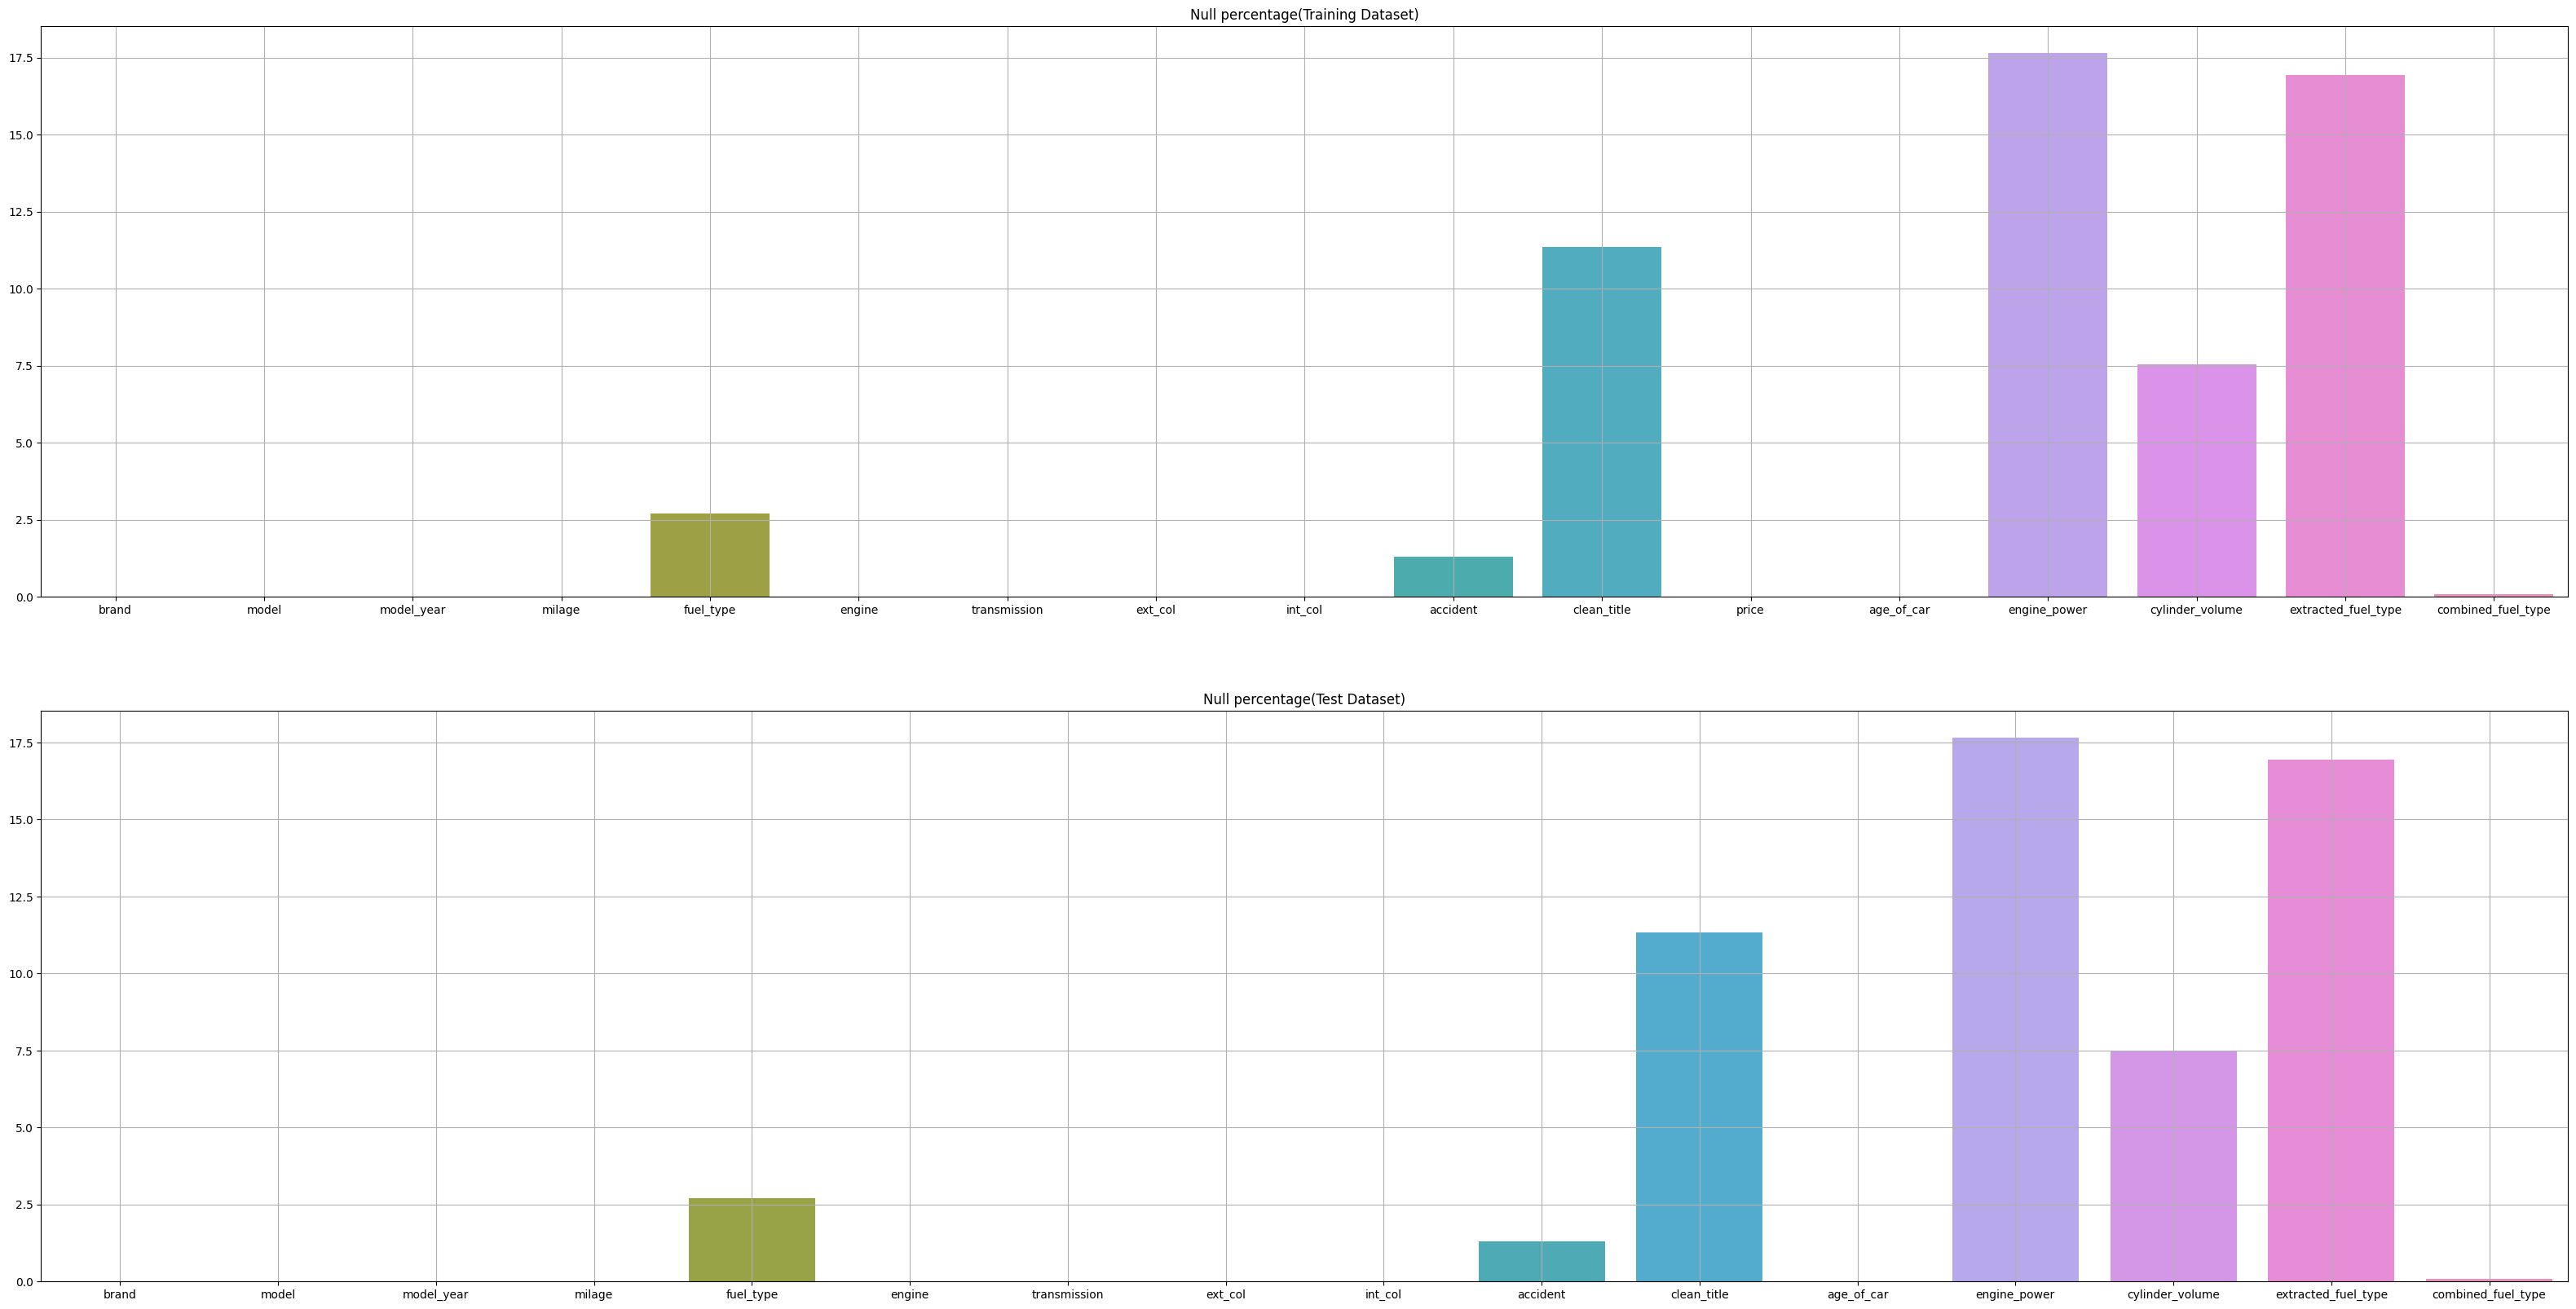

In [110]:
# Handling null values before encoding 
def percentage_null(dataset, features):
    null_per = []
    for feat in features:
        null_value = dataset[feat].isnull().sum()
        null_percentage = null_value*100/(dataset.shape[0])
        null_per.append(null_percentage)
    return null_per

def display_null_percentage(per_arr, features):
    for feat, null_per in zip(features, per_arr):
        print(f"{feat}: {null_per}")


train_dataset_nullper = percentage_null(train_dataset_hlfilt, list(train_dataset_hlfilt.columns))
test_dataset_nullper = percentage_null(test_dataset_hlfilt, list(test_dataset_hlfilt.columns))

print(f"*******************Training Dataset**********************")
display_null_percentage(train_dataset_nullper, list(train_dataset_hlfilt.columns))
print("\n")
print(f"*******************Training Dataset**********************")
display_null_percentage(test_dataset_nullper, list(test_dataset_hlfilt.columns))

# Barplot of null values
# Training dataset & Test dataset null value percentage
fig, axearr = plt.subplots(2,1, figsize=(40,20))
axearr[0].set_title('Null percentage(Training Dataset)')
sns.barplot(x=list(train_dataset_hlfilt.columns), y=train_dataset_nullper, ax=axearr[0])
axearr[0].grid()
axearr[1].set_title('Null percentage(Test Dataset)')
sns.barplot(x=list(test_dataset_hlfilt.columns), y=test_dataset_nullper, ax=axearr[1])
axearr[1].grid()
plt.show()



In [111]:
# Handling null values part-1
# from the above data for null-percentage --> I can remove clean_title(useless feature), extracted_fuel_type, fuel_type, do impution on accident, engine_powe and cylinder volume
# engine feature can be removed as encoding that directly will lead to a lot of categories and hard to train eventually, but I did feature extraction from it to get three new features which ig is a win-win
train_dataset_nafilt = train_dataset_hlfilt.drop(columns=['clean_title', 'fuel_type', 'extracted_fuel_type', 'engine'], axis=1, inplace=False)
test_dataset_nafilt = test_dataset_hlfilt.drop(columns=['clean_title', 'fuel_type', 'extracted_fuel_type', 'engine'], axis=1, inplace=False)


print(f"{train_dataset_nafilt}")

                brand                     model  model_year  milage  \
id                                                                    
0                mini             cooper s base        2007  213000   
1             lincoln                     ls v8        2002  143250   
2           chevrolet         silverado 2500 lt        2002  136731   
3             genesis          g90 5.0 ultimate        2017   19500   
4       mercedes-benz               metris base        2021    7388   
...               ...                       ...         ...     ...   
188528       cadillac     escalade esv platinum        2017   49000   
188529  mercedes-benz  amg c 43 amg c 43 4matic        2018   28600   
188530  mercedes-benz    amg glc 63 base 4matic        2021   13650   
188531           audi          s5 3.0t prestige        2022   13895   
188532        porsche                macan base        2016   59500   

       transmission                    ext_col int_col  \
id                

In [112]:
# checking for null values 
print(f"***************Training Dataset***************\n") 
print(f"{train_dataset_nafilt.isnull().sum()}")       
print(f"\n")

print(f"***************Test Dataset***************\n") 
print(f"{test_dataset_nafilt.isnull().sum()}")       
print(f"\n")

***************Training Dataset***************

brand                     0
model                     0
model_year                0
milage                    0
transmission              0
ext_col                   0
int_col                   0
accident               2452
price                     0
age_of_car                0
engine_power          33259
cylinder_volume       14214
combined_fuel_type      177
dtype: int64


***************Test Dataset***************

brand                     0
model                     0
model_year                0
milage                    0
transmission              0
ext_col                   0
int_col                   0
accident               1632
age_of_car                2
engine_power          22181
cylinder_volume        9407
combined_fuel_type      112
dtype: int64




In [113]:
# Encoding the catagorical features
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_dataset_enc = train_dataset_nafilt.copy()
test_dataset_enc = test_dataset_nafilt.copy()

enc.fit(train_dataset_enc[['brand', 'model', 'transmission','ext_col', 'int_col', 'accident', 'combined_fuel_type']])
train_dataset_enc[['brand', 'model', 'transmission','ext_col', 'int_col', 'accident', 'combined_fuel_type']] = enc.transform(train_dataset_enc[['brand', 'model', 'transmission','ext_col', 'int_col', 'accident', 'combined_fuel_type']])
test_dataset_enc[['brand', 'model', 'transmission','ext_col', 'int_col', 'accident', 'combined_fuel_type']] = enc.transform(test_dataset_enc[['brand', 'model', 'transmission','ext_col', 'int_col', 'accident', 'combined_fuel_type']])

In [114]:
print(f"******************Training Dataset Encoded***************************\n")
print(f"{train_dataset_enc}")

******************Training Dataset Encoded***************************

        brand   model  model_year  milage  transmission  ext_col  int_col  \
id                                                                          
0        37.0   460.0        2007  213000           0.0    313.0     69.0   
1        28.0   961.0        2002  143250           0.0    264.0      8.0   
2         9.0  1556.0        2002  136731           0.0     36.0     69.0   
3        15.0   761.0        2017   19500           2.0     26.0     12.0   
4        35.0  1063.0        2021    7388           0.0     26.0      8.0   
...       ...     ...         ...     ...           ...      ...      ...   
188528    8.0   607.0        2017   49000           2.0    305.0      8.0   
188529   35.0   227.0        2018   28600           0.0    305.0     12.0   
188530   35.0   244.0        2021   13650           0.0    305.0     12.0   
188531    3.0  1477.0        2022   13895           0.0     79.0     12.0   
18853

In [115]:
print(f"******************Training Dataset Encoded***************************\n")
check_features(train_dataset_enc, list(train_dataset_enc.columns))

******************Training Dataset Encoded***************************

brand
14.0    23088
35.0    19172
5.0     17028
9.0     16335
3.0     10887
43.0    10612
26.0     9525
54.0     8850
27.0     8643
22.0     6474
8.0      4674
44.0     4249
39.0     3930
53.0     3738
20.0     3276
16.0     3215
11.0     3133
33.0     2719
24.0     2497
28.0     2423
51.0     2381
0.0      2282
17.0     2101
19.0     2045
55.0     1765
21.0     1319
4.0      1155
37.0     1064
15.0      969
7.0       940
31.0      939
25.0      809
10.0      727
56.0      723
1.0       682
45.0      590
46.0      561
38.0      551
42.0      538
18.0      520
12.0      359
34.0      243
2.0       238
48.0      148
49.0      120
30.0       69
36.0       57
29.0       52
13.0       44
47.0       22
23.0       17
52.0        8
40.0        7
6.0         7
41.0        7
50.0        3
32.0        3
Name: count, dtype: int64

model
674.0     2945
977.0     2229
355.0     1709
983.0     1622
1122.0    1526
          ... 
90

In [116]:
print(f"{test_dataset_enc}")

        brand   model  model_year  milage  transmission  ext_col  int_col  \
id                                                                          
188533   26.0  1367.0        2015   98000           0.0    305.0      8.0   
188534   26.0  1354.0        2020    9142           0.0    264.0     12.0   
188535   14.0   641.0        2022   28121           0.0    305.0     55.0   
188536    3.0   182.0        2016   61258           0.0    262.0     12.0   
188537    3.0   181.0        2018   59000           0.0    128.0     12.0   
...       ...     ...         ...     ...           ...      ...      ...   
314218   35.0   782.0        2014   83315           0.0     26.0     12.0   
314219    3.0  1257.0        2019   29336           0.0    305.0     12.0   
314220    3.0   184.0        2012   77634           0.0     26.0     12.0   
314221    3.0  1253.0        2012  112000           0.0     26.0     12.0   
314222    9.0  1651.0        2018   66840           0.0    264.0     12.0   

In [117]:
print(f"******************Test Dataset Encoded***************************\n")
check_features(test_dataset_enc, list(test_dataset_enc.columns))

******************Test Dataset Encoded***************************

brand
14.0    15265
35.0    12875
5.0     11286
9.0     10698
3.0      7289
43.0     7153
26.0     6348
54.0     6084
27.0     5729
22.0     4412
8.0      3059
44.0     2753
39.0     2674
53.0     2387
20.0     2123
16.0     2094
11.0     2071
33.0     1770
24.0     1750
28.0     1593
51.0     1591
0.0      1567
17.0     1436
19.0     1308
55.0     1222
21.0      934
4.0       789
37.0      697
7.0       651
15.0      643
31.0      619
56.0      576
25.0      547
10.0      514
1.0       467
45.0      390
46.0      383
38.0      367
18.0      342
42.0      341
12.0      251
34.0      165
2.0       144
48.0       97
49.0       62
30.0       42
36.0       39
13.0       37
29.0       19
47.0       11
23.0       10
32.0        7
40.0        4
6.0         3
52.0        2
Name: count, dtype: int64

model
674.0     1923
977.0     1412
355.0     1111
983.0     1005
1122.0     938
          ... 
481.0        1
729.0        1
629.

In [118]:
# checking null values and its percentage after encoding
print(f"Training Dataset:\n")
print(f"{train_dataset_enc.isnull().sum()}\n")
print(f"Test Dataset:\n")
print(f"{test_dataset_enc.isnull().sum()}")

Training Dataset:

brand                     0
model                     0
model_year                0
milage                    0
transmission              0
ext_col                   0
int_col                   0
accident               2452
price                     0
age_of_car                0
engine_power          33259
cylinder_volume       14214
combined_fuel_type      177
dtype: int64

Test Dataset:

brand                     0
model                     0
model_year                0
milage                    0
transmission              0
ext_col                   0
int_col                   0
accident               1632
age_of_car                2
engine_power          22181
cylinder_volume        9407
combined_fuel_type      112
dtype: int64


In [119]:
# checking for outliers and its percentage as well as plot
def get_outlier_percentage(dataset, features):
    out_per = []
    for feat in features:
        q1 = dataset[feat].quantile(0.25)
        q3 = dataset[feat].quantile(0.75)
        IQR = q3-q1
        val_out = dataset[feat][(dataset[feat]<=q1-1.5*IQR) | (dataset[feat]>=q3+1.5*IQR)]
        out_per_val = (val_out.shape[0]*100/dataset.shape[0])
        out_per.append((feat, out_per_val))
    return out_per

train_out_per = get_outlier_percentage(train_dataset_enc, ['model_year', 'milage', 'age_of_car', 'engine_power', 'cylinder_volume'])
for feat,per in train_out_per:
    print(f"{feat}: {per}")

model_year: 2.7220698763611675
milage: 0.9367060408522646
age_of_car: 2.7220698763611675
engine_power: 0.9886863307749837
cylinder_volume: 0.06577097908588947


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

<Figure size 2000x2000 with 0 Axes>

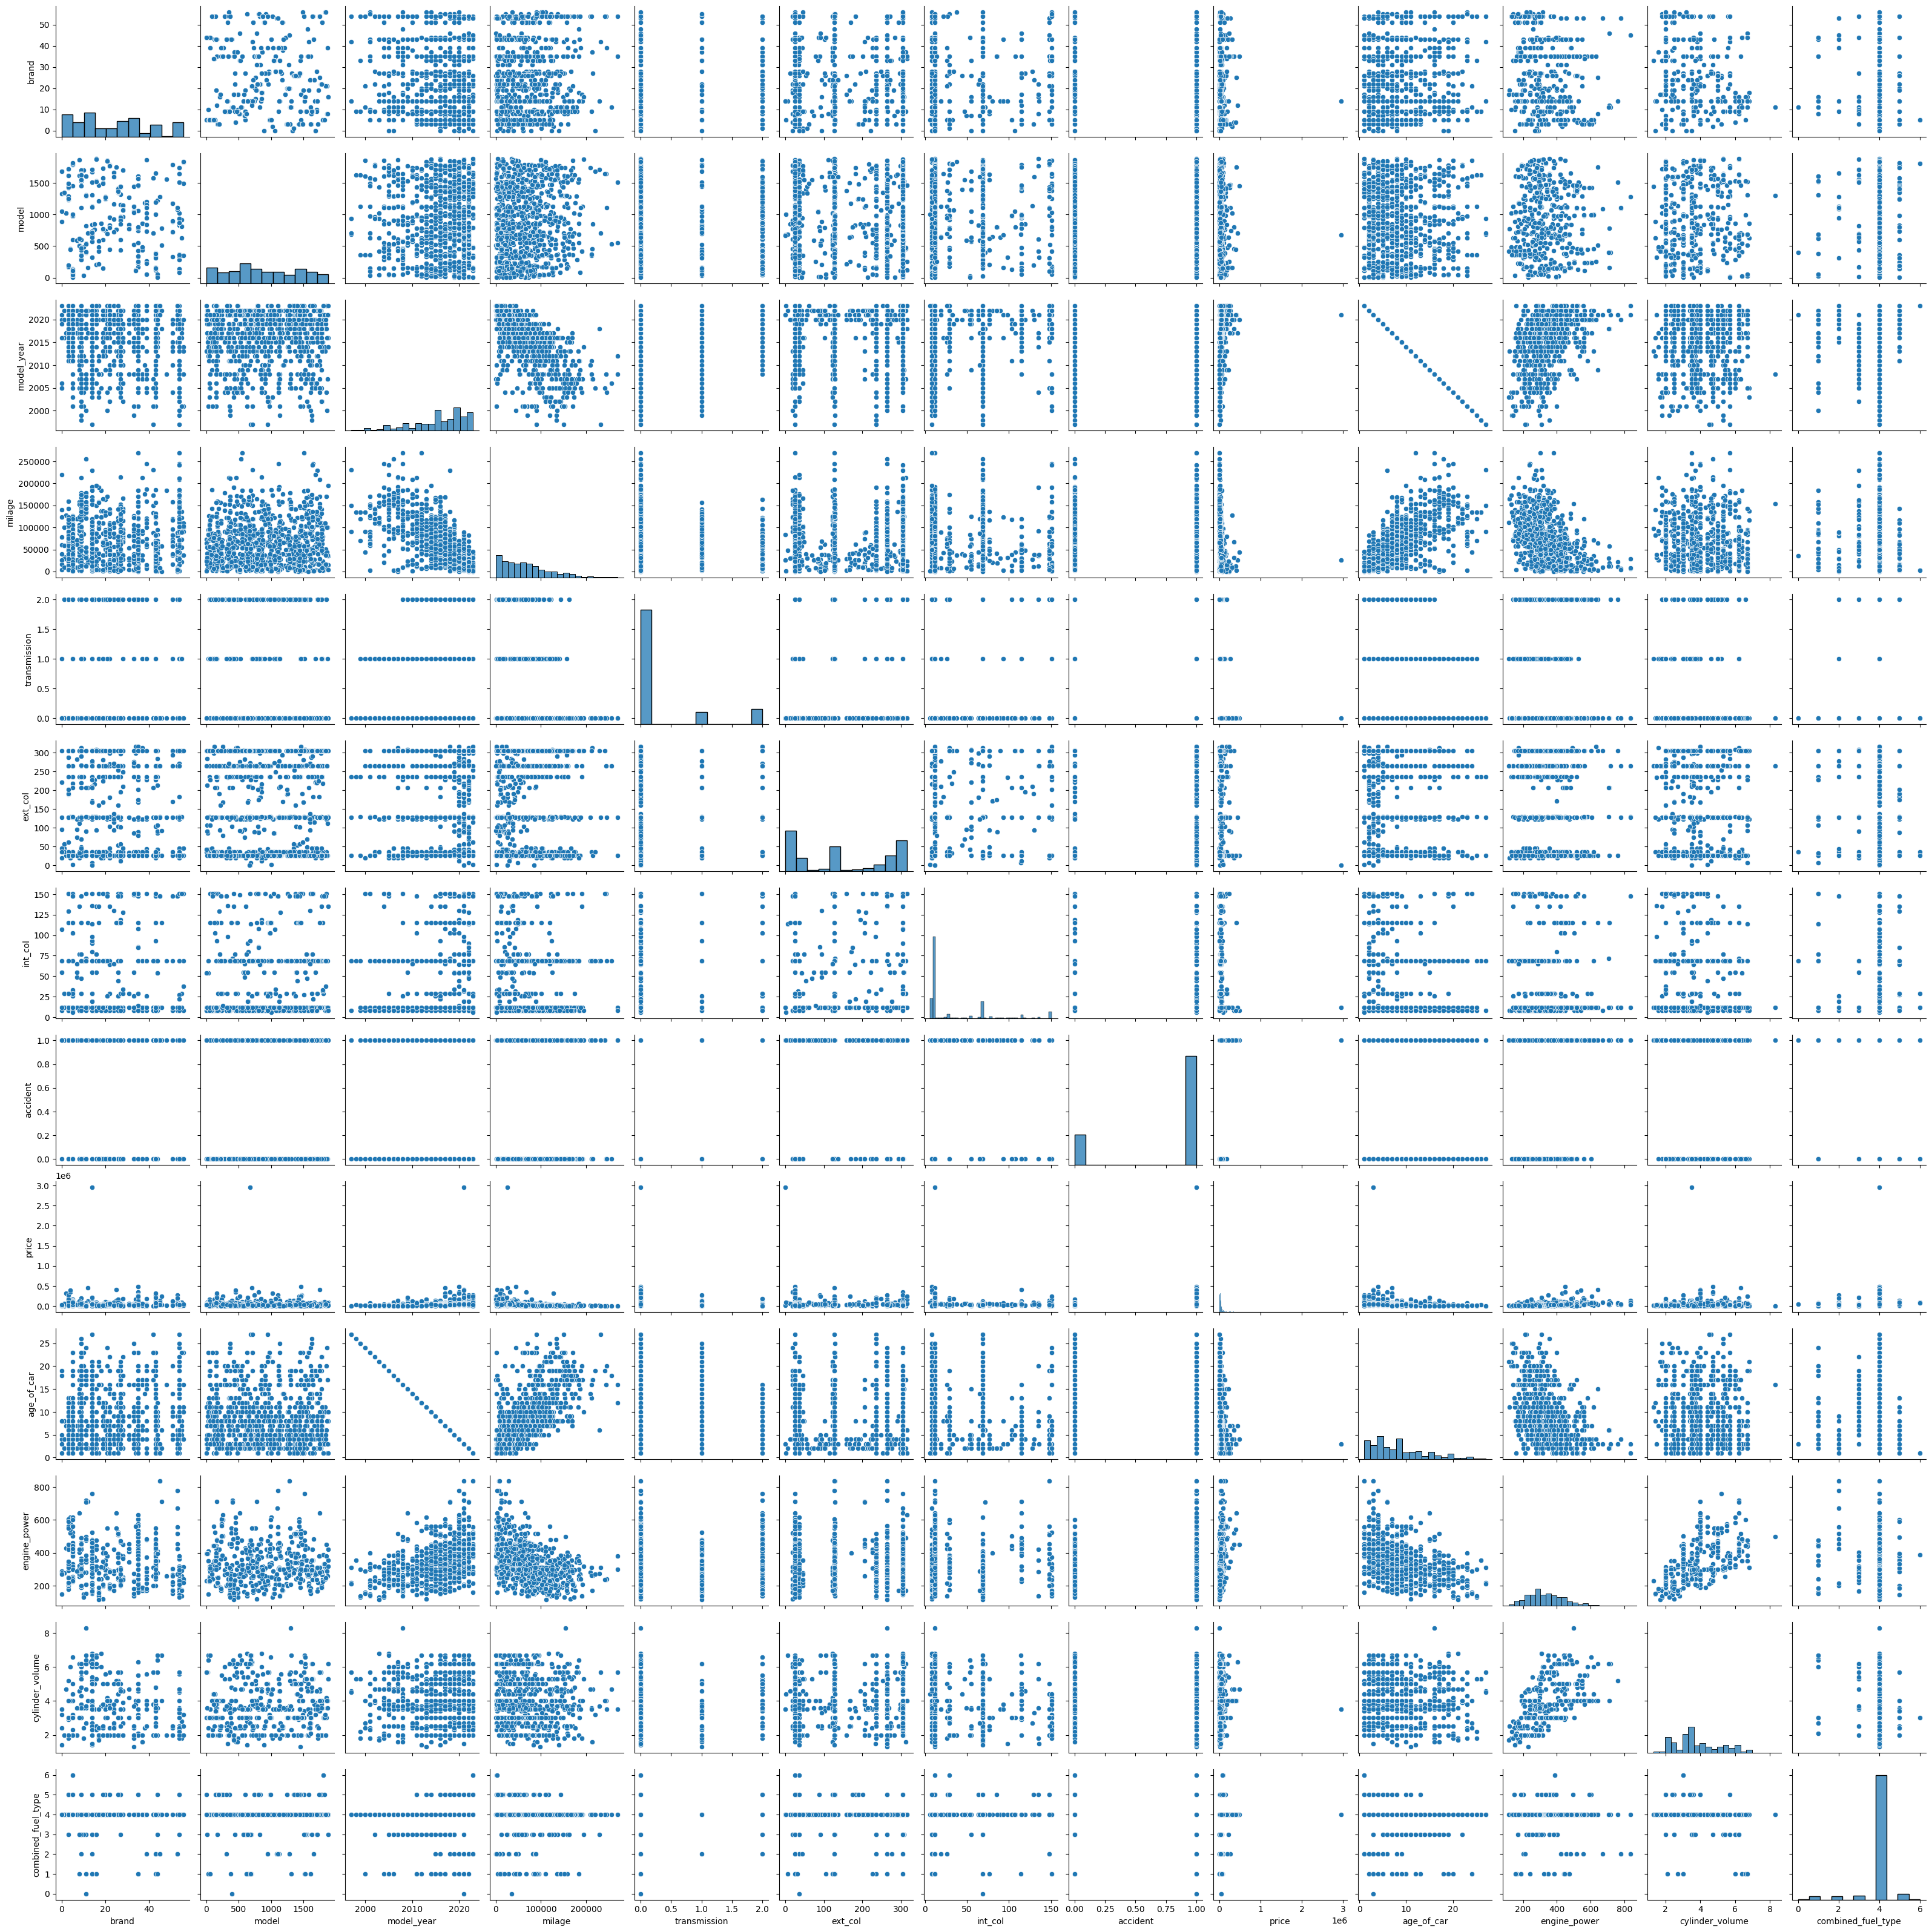

In [120]:
# correlation heatmap chart
fig = plt.figure(figsize=(20,20))
sns.pairplot(train_dataset_enc.head(1000))
plt.show()


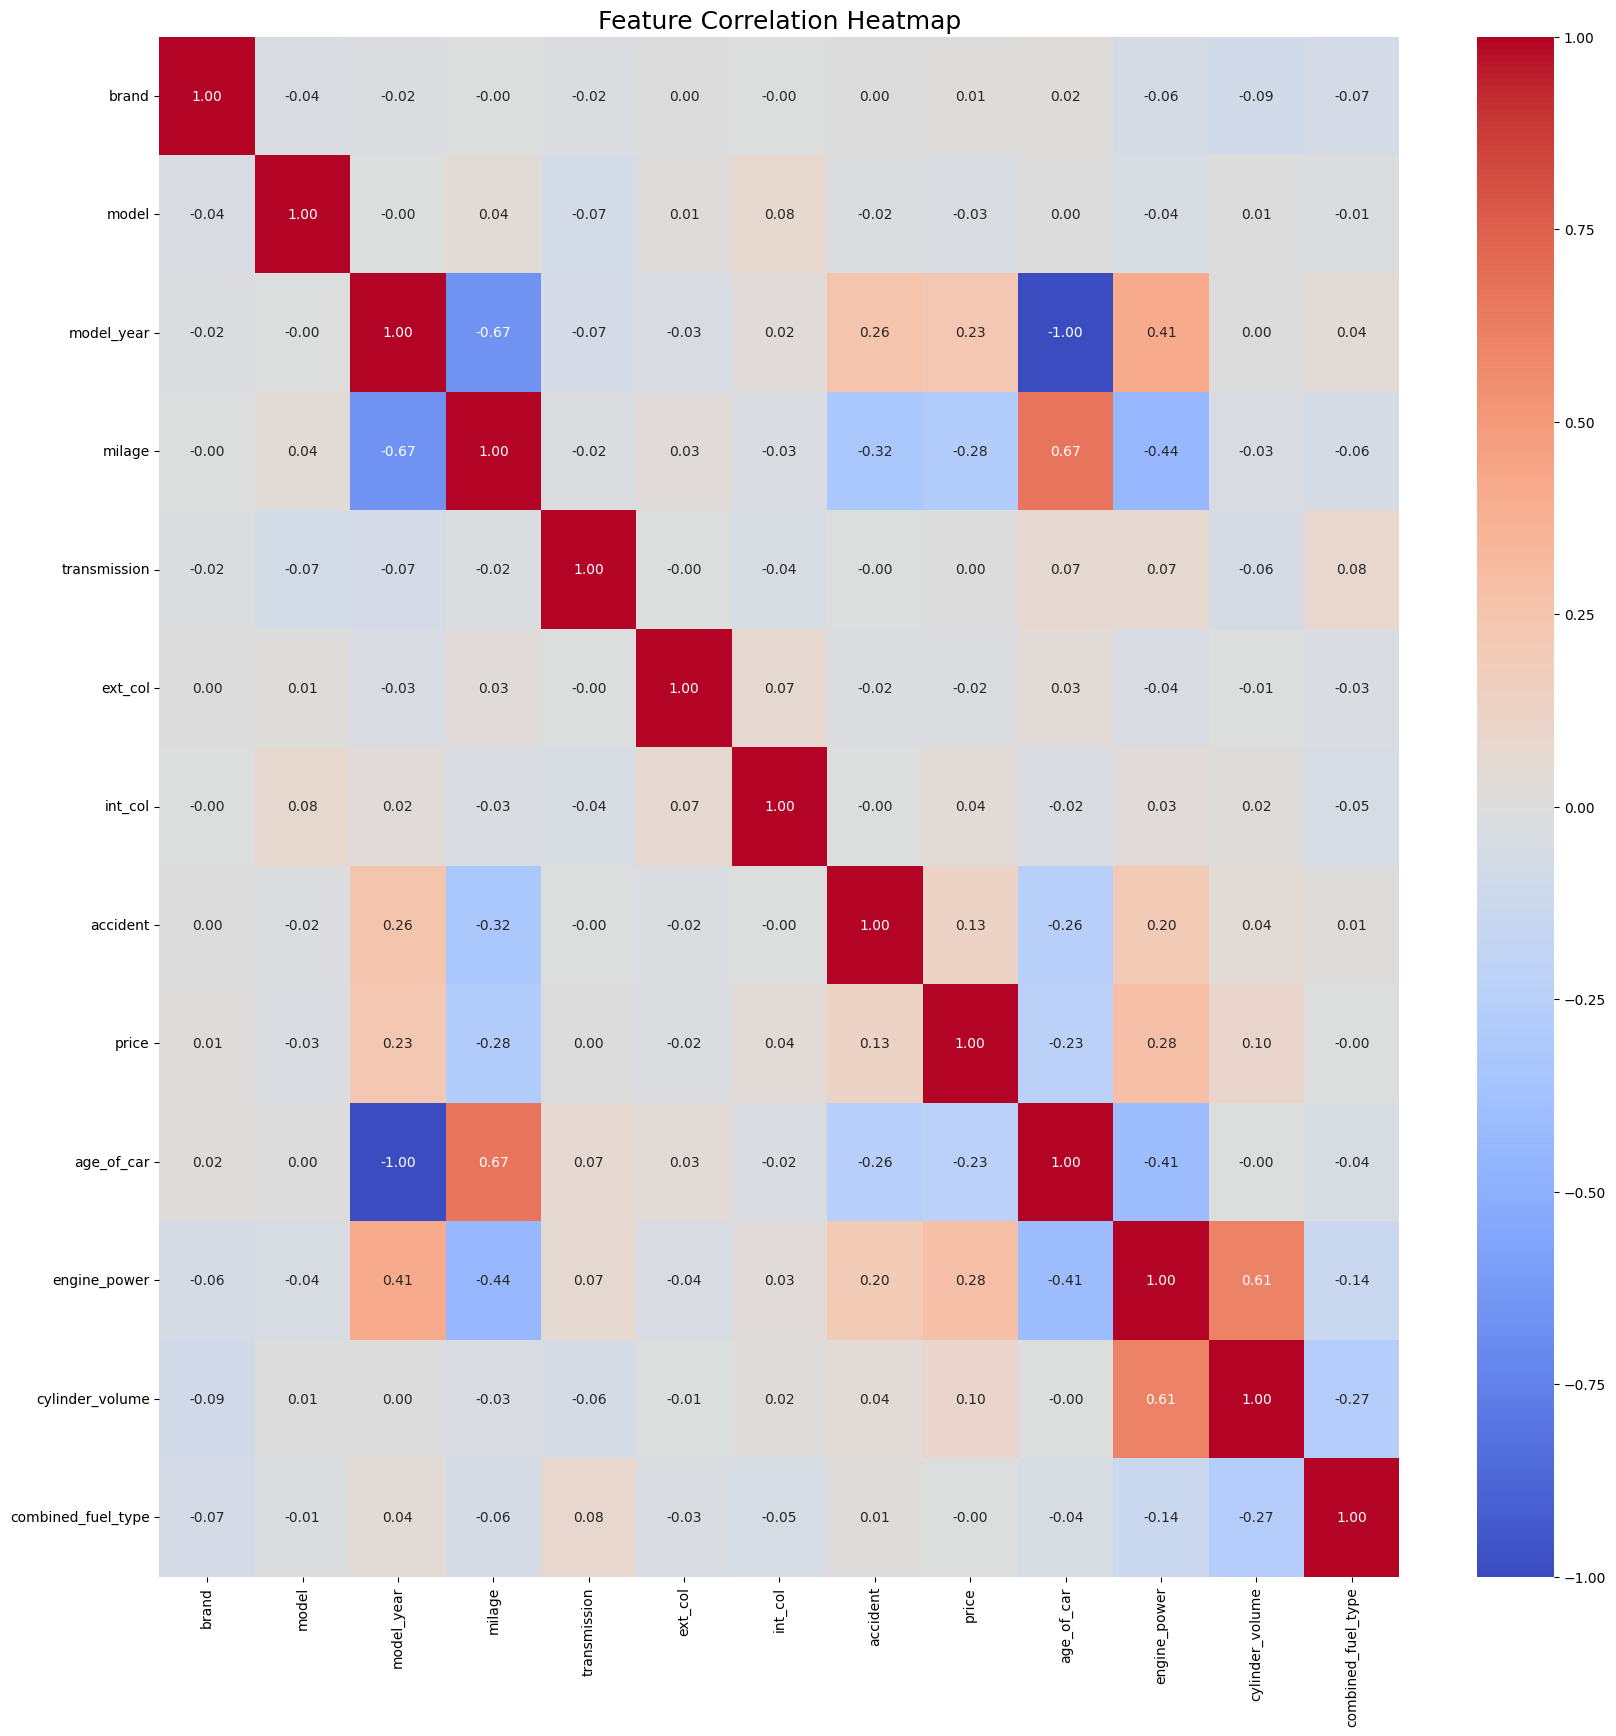

In [121]:
# Create a heatmap of the Pearson correlation matrix
fig = plt.figure(figsize=(20, 20))  # Adjust the size of the figure
sns.heatmap(train_dataset_enc.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap', fontsize=18)  # Title of the heatmap
plt.show()



In [122]:
# dropping model_year as age_of_car is derived from it
train_dataset_enc.drop(columns=['model_year'], axis=1, inplace=True)
test_dataset_enc.drop(columns=['model_year'], axis=1, inplace=True)

In [123]:
# type casting categorical features into integers
new_features = [col for col in list(train_dataset_enc.columns) if col!= 'price']
print(f"{new_features}\n")

['brand', 'model', 'milage', 'transmission', 'ext_col', 'int_col', 'accident', 'age_of_car', 'engine_power', 'cylinder_volume', 'combined_fuel_type']



In [124]:
# Null values handling part-2
# Imputation of Null Values in the dataset
def feature_imputer(imp, dataset, features):
    dataset_copy = dataset.copy()
    for feat in features:
        dataset_copy[feat] = imp.fit_transform(dataset_copy[[feat]])
    return dataset_copy
        
    
train_dataset_enc_copy = train_dataset_enc.copy() 
test_dataset_enc_copy = test_dataset_enc.copy()

imputer = KNNImputer(n_neighbors=5)
# Perform the imputation only on the 'accident' column using other features as context
train_dataset_enc_copy = feature_imputer(imputer, train_dataset_enc_copy, ['accident', 'engine_power', 'cylinder_volume', 'combined_fuel_type'])
test_dataset_enc_copy = feature_imputer(imputer, test_dataset_enc_copy, ['accident', 'engine_power', 'cylinder_volume', 'combined_fuel_type', 'age_of_car'])

In [125]:
# Display the imputed dataset (accident feature after imputation)
def type_cast_features(dataset, features):
    dataset_copy = dataset.copy()
    for feat in features:
        dataset_copy[feat] = dataset_copy[feat].astype(int)
    return dataset_copy

train_dataset_enc_copy = type_cast_features(train_dataset_enc_copy, ['brand', 'model', 'transmission', 'ext_col', 'int_col', 'accident', 'combined_fuel_type'])
test_dataset_enc_copy = type_cast_features(test_dataset_enc_copy, ['brand', 'model', 'transmission', 'ext_col', 'int_col', 'accident', 'combined_fuel_type'])

In [126]:
# rechecking null values again
print(f"Training Dataset:\n")
print(f"{train_dataset_enc_copy.isnull().sum()}\n")
print(f"Test Dataset:\n")
print(f"{test_dataset_enc_copy.isnull().sum()}")

Training Dataset:

brand                 0
model                 0
milage                0
transmission          0
ext_col               0
int_col               0
accident              0
price                 0
age_of_car            0
engine_power          0
cylinder_volume       0
combined_fuel_type    0
dtype: int64

Test Dataset:

brand                 0
model                 0
milage                0
transmission          0
ext_col               0
int_col               0
accident              0
age_of_car            0
engine_power          0
cylinder_volume       0
combined_fuel_type    0
dtype: int64


In [127]:
# Normalization of numerical datas
print(f"mean: {train_dataset_enc_copy['milage'].mean()}")
print(f"std_dev: {train_dataset_enc_copy['milage'].std()}\n")
print(f"mean: {train_dataset_enc_copy['engine_power'].mean()}")
print(f"std_dev: {train_dataset_enc_copy['engine_power'].std()}\n")

def feature_normalization(train_dataset, features):
    train_dataset_copy = train_dataset.copy()
    train_data = train_dataset_copy[features].to_numpy()
    norm1_layer = tf.keras.layers.Normalization(axis=-1)
    norm1_layer.adapt(train_data)    
    train_dataset_copy[features] = pd.DataFrame(data=norm1_layer(train_data).numpy(), columns=features)

    return train_dataset_copy
def ZScalerNormalization(dataset, features):
    dataset_copy = dataset.copy()
    for feat in features:
        feat_mean = dataset_copy[feat].mean()
        feat_std = dataset_copy[feat].std()
        data = dataset_copy[feat]
        dataset_copy[feat] = (data-feat_mean)/feat_std
    
    return dataset_copy


train_dataset_norm = feature_normalization(train_dataset_enc_copy,['milage', 'engine_power'])
test_dataset_norm = ZScalerNormalization(test_dataset_enc_copy,['milage', 'engine_power'])

mean: 65705.2951737892
std_dev: 49798.15807575411

mean: 343.26385615106204
std_dev: 104.12340596978258



In [134]:
print(f"Training Dataset:\n")
print(f"{train_dataset_norm.describe()}")
print(f"Test Dataset:\n")
print(f"{test_dataset_norm}")

Training Dataset:

               brand          model        milage   transmission  \
count  188533.000000  188533.000000  1.885330e+05  188533.000000   
mean       23.259636     869.693481 -3.212081e-08       0.318252   
std        15.869446     523.518688  1.000003e+00       0.669523   
min         0.000000       0.000000 -1.317428e+00       0.000000   
25%         9.000000     431.000000 -8.351797e-01       0.000000   
50%        21.000000     835.000000 -1.590484e-01       0.000000   
75%        35.000000    1330.000000  5.963029e-01       0.000000   
max        56.000000    1892.000000  6.813417e+00       2.000000   

             ext_col        int_col       accident         price  \
count  188533.000000  188533.000000  188533.000000  1.885330e+05   
mean      156.364270      32.854492       0.766518  4.387802e+04   
std       115.984131      39.460388       0.423047  7.881952e+04   
min         0.000000       0.000000       0.000000  2.000000e+03   
25%        26.000000      12

In [129]:
# train, test split
X = train_dataset_norm.drop(columns=['price'], axis=1, inplace=False)
y = train_dataset_norm['price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train)

        brand  model    milage  transmission  ext_col  int_col  accident  \
id                                                                         
31223      11    398 -0.476029             0      128       12         1   
78029      35    805 -0.355542             0      305        8         1   
9549       35   1575  0.548108             0      129        8         0   
121606     24   1599  1.759642             0       26       69         1   
172872     27    910  0.063571             0      264       12         0   
...       ...    ...       ...           ...      ...      ...       ...   
73349      54    367 -0.018661             0       26       69         1   
109259     20   1277 -0.287266             2      128      151         1   
50057      22   1778 -1.230336             0      129        8         1   
5192       17    418  0.829244             0      305        8         1   
128037     14    319 -1.024243             0      313      151         1   

        age

In [140]:
# Model training 
############# using (SGDRegressor) ##########################
model = SGDRegressor(
    loss='epsilon_insensitive',
    penalty='l2',
    alpha=0.001,
    max_iter=1000,
    tol=0.00001,
    shuffle=True,
    verbose=4,
    random_state=42,
    learning_rate='invscaling',
    eta0=0.01,
    early_stopping=False
)

rf_model = RandomForestRegressor(
    criterion='squared_error',
    n_estimators=100,      # Number of trees in the forest
    max_depth=10,        # Maximum depth of the tree
    min_samples_split=2,   # Minimum number of samples required to split an internal node
    min_samples_leaf=1,    # Minimum number of samples required to be at a leaf node
    random_state=42,        # For reproducibility
    verbose=4,
    
)

# model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    9.3s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66

[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   37.6s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


RandomForestRegressor(max_depth=10, random_state=42, verbose=4)

In [142]:
train_predictions = rf_model.predict(X_train)
test_predictions = rf_model.predict(X_valid)

[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.3s


In [146]:
# checking the accuracy of model using MSE
print(f"\nTraining Set Performance:")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_train, train_predictions)}")
print(f"Root MSE: {np.sqrt(mean_squared_error(y_train, train_predictions))}")
print(f"r2_score: {r2_score(y_train, train_predictions)}\n")
print(f"\nTesting Set Performance:")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_valid, test_predictions)}")
print(f"Root MSE: {np.sqrt(mean_squared_error(y_valid, test_predictions))}")
print(f"r2_score: {r2_score(y_valid, test_predictions)}")


Training Set Performance:
Mean Squared Error (MSE): 3968936317.638519
Root MSE: 62999.494582405336
r2_score: 0.39706333738160793


Testing Set Performance:
Mean Squared Error (MSE): 4118942570.478535
Root MSE: 64178.98854359217
r2_score: 0.12942065459026553


In [144]:
param_grid = {
    'n_estimators': [100],            # Number of trees
    'max_depth': [10, 20],           # Maximum depth of trees
    'min_samples_split': [2, 5],           # Minimum samples required to split an internal node
    'min_samples_leaf': [1],             # Minimum samples required to be at a leaf node
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, verbose=4, n_jobs=2)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Output the best parameters and the best score


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   29.5s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   30.2s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   29.9s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   29.8s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Do

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   29.5s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   30.2s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   30.1s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   29.7s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:   13.7s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:   13.8s
[Parallel(n_jobs=1)]: Do


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 7

[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   55.5s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   55.7s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:   13.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:   13.5s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   53.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   55.1s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.9s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:   13.6s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:   13.2s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   53.9s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   53.1s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:   13.1s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:   13.1s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97

[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   54.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   53.3s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.8s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    9.0s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66

[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   36.4s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=10, random_state=42,
                                             verbose=4),
             n_jobs=2,
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [1],
                         'min_samples_split': [2, 5], 'n_estimators': [100]},
             verbose=4)

In [149]:
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}\n")
best_model = grid_search.best_estimator_
train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_valid)

# checking the accuracy of model using MSE
print(f"\nTraining Set Performance:")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_train, train_predictions)}")
print(f"Root MSE: {np.sqrt(mean_squared_error(y_train, train_predictions))}")
print(f"r2_score: {r2_score(y_train, train_predictions)}\n")
print(f"\nTesting Set Performance:")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_valid, test_predictions)}")
print(f"Root MSE: {np.sqrt(mean_squared_error(y_valid, test_predictions))}")
print(f"r2_score: {r2_score(y_valid, test_predictions)}")


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Score: 0.10675020040873011



[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.1s



Training Set Performance:
Mean Squared Error (MSE): 3968936317.638519
Root MSE: 62999.494582405336
r2_score: 0.39706333738160793


Testing Set Performance:
Mean Squared Error (MSE): 4118942570.478535
Root MSE: 64178.98854359217
r2_score: 0.12942065459026553


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.3s


In [ ]:
# Define the parameter grid for SGDRegressor
param_grid = {
    'loss': ['epsilon_insensitive'],
    'penalty': ['l2'],  # Test different regularizations
    'alpha': [0.001],  # Regularization strength
    'max_iter': [1000],  # Number of iterations
    'learning_rate': ['invscaling'],
    'eta0': [0.01],  # Initial learning rate
    'tol': [0.00001]  # Tolerance for stopping criteria
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=4, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Output the best parameters and the best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

In [147]:
test_predictions = rf_model.predict(test_dataset_norm)

[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    1.1s


In [148]:
# submission csv creator
test_dataset_norm['id'] = test_dataset_norm.index
submission = pd.DataFrame({
    'id': test_dataset_norm['id'],  
    'price': test_predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

Submission file created!
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
[CV 4/5] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.051 total time=  56.6s
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
b

In [ ]:
### Training using a shallow NNs model with linear activation
def shallow_model_linear(input_dataset):
    model = tf.keras.Sequential()
    # input_layer
    model.add(tf.keras.layers.Input(shape=(input_dataset.shape[0],), batch_size=32)
    # hidden_layer-1
    model.add(tf.keras.layers.Dense(units=3, activation='layer'))
              
    # output layer
    model.add(tf.keras.layers.Dense(units=1, activation='linear'))
    
    return model
    